# Segmentez des clients d'un site e-commerce

- **Projet 5 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 3 : Simulation de la stabilité des segments au cours du temps

<img  width="76" height="30" src="https://olist.com/wp-custom/themes/olist20/assets/img/brand.svg" alt="Logo olist">


## 1.2 Rappel de la mission

[Olist](https://olist.com/), une entreprise brésilienne qui propose une solution de vente sur les
marketplaces en ligne, souhaite une **segmentation des clients** que ses équipes d'e-commerce pourront
utiliser au quotidien pour leurs campagnes de communication.

- **comprendre les différents types d'utilisateurs**, grâce à leur comportement et à leurs données
  personnelles, en regroupant des clients de profils similaires. Ces catégories pourront être
  utilisées par l’équipe Marketing pour mieux communiquer.

- **fournir à l’équipe marketing une description actionable** de votre segmentation et de sa logique
  sous-jacente pour une utilisation optimale

- **une proposition de contrat de maintenance**, (fréquence à laquelle la segmentation doit être
  mise à jour pour rester pertinente), basée sur une analyse de la stabilité des segments au cours
  du temps.


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook


In [1]:
# si ce notebook ne marche pas avec les versions
# des bibliothèques dans votre environnement, alors
# decommentarise la ligne suivant pour des versions testées:

# %pip install -r requirements.txt


In [2]:
def install_libraries(required={}) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas', 'matplotlib', 'seaborn',
                      'scipy', 'scikit-learn', 'statsmodels',
                      'missingno', 'dython', 'squarify', 'yellowbrick', 'plotly'}
install_libraries(required_libraries)


### 1.2.1 Import des bibliothèques


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import missingno as msno
import sklearn
import dython
import squarify
import plotly.express as px
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



### 1.2.2 Liste des versions des bibliothèques utilisées


In [4]:
from platform import python_version

python_version()
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2; scipy==1.7.3; missingno==0.5.0; sklearn==1.0.2; dython==0.6.8


### 1.2.3 Configuration défauts d'affichage


In [5]:
from sklearn import set_config
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 800)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")

set_config(display='diagram')
# displays HTML representation in a jupyter context

# Set random_state pour réproduire les resultats
# Pour des resultats différents sur chaque execution, set RANDOM_STATE=None

RANDOM_STATE = 0


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [6]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images/notebook'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


In [7]:
def to_png(fig_name=None) -> None:
    """
    Enregistre l'image dans un fichier,
    il faut appeler avant plt.show() pour pouvoir ajuster la taille de l'image
    avec bbox_inches=tight pour être sûr d'inclure le titre / legend entier.
    """

    def get_title():
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = fig_name.replace(' ', '_').replace(':', '-').replace(
            '.', '-').replace('/', '_').replace('>', 'gt.').replace('<', 'lt.')
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [8]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


### Evaluation de la stabilité

- L’objectif est de déterminer au bout de **combien de temps**

  - le modèle de clustering entraîné initialement proposé (donc « fit ») devient obsolète
  - (quand les prédictions, « predict », ne sont plus pertinentes),
  - nécessitant d’entraîner un nouveau modèle de clustering.

- Il s’agit de comparer

  - les numéros de clusters à T1 du fichier F1, selon que l’on utilise le modèle initial créé à
    T0(M0) via un « predict », ou le modèle créé à T1 via un « fit ».

- Il s’agit donc :
  - de simuler plusieurs périodes T1, T2 à Tt, et
  - d’afficher l’évolution de l’ARI.
- Si l’ARI passe en dessous de 0.8 (correspond environ à 0,9 en accuracy)
  - il est sûrement pertinent de reproposer un entraînement de modèle au client.


### Step 1: Les périods de temps


In [9]:
OUT_DIR = 'data/out'
df_clients = pd.read_csv(f'{OUT_DIR}/clients.csv')
df_clients.head()


,customer_unique_id,dernier_achat,Frequency,MonetaryValue,Recency,mean_nb_payments,review_score,delivery_time,delivery_delay,distance_customer_seller,freight_percent,payment_mode,favourite_category,time_of_day,weekday,products_per_order
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,141.90,160,8.00,5.00,6.00,-4.00,110.59,0.08,credit_card,bed_bath,10.00,3.00,1.00
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,27.19,163,1.00,4.00,3.00,-4.00,22.19,0.30,credit_card,health_parfum,11.00,0.00,1.00
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,86.22,585,8.00,3.00,25.00,-2.00,516.69,0.20,credit_card,office_tech,21.00,4.00,1.00
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,43.62,369,4.00,4.00,20.00,-11.00,2480.13,0.40,credit_card,office_tech,20.00,3.00,1.00
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,196.89,336,6.00,5.00,13.00,-7.00,154.40,0.09,credit_card,office_tech,19.00,1.00,1.00


In [10]:
print(df_clients['dernier_achat'].min())
print(df_clients['dernier_achat'].max())
print(df_clients['dernier_achat'].dtype)


2016-10-03 16:56:50
2018-08-29 15:00:37
object


In [11]:
df_clients['dernier_achat'] = pd.to_datetime(df_clients['dernier_achat'])
print(df_clients['dernier_achat'].dtype)


datetime64[ns]


<function matplotlib.pyplot.show(close=None, block=None)>

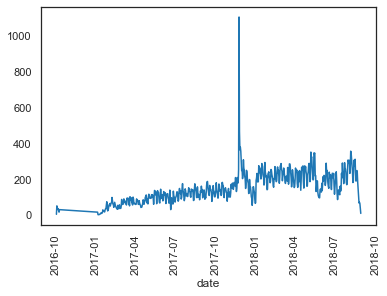

In [12]:
df_clients['date'] = df_clients['dernier_achat'].dt.date
df_clients.groupby('date')['customer_unique_id'].count().plot(kind='line')
plt.xticks(rotation=90)
plt.show


Les données entières sont disponibles pour 18 mois, du 01/01/2017 à 01/08/2018 (données avant janvier 2017 sont trop éparses; données d'aout 2018 ne sont pas complets car il y a les achats pas encore livrés)

On va comparer des prévisions basé sur 12 mois de données, pour minimiser les fluctuations sasonales

Pour la stabilité des clusters, on va comparer les clusters _**fitted**_ de **données T0: de 01/08/2017 à 01/08/2018** avec les _**prédictions**_ de clusters chaque 1, 3 ou 6 mois antérieurs:

- Chaque 6 mois: compare le **fit T0** avec les prédictions 6 mois avant des **données T6 : du 01/02/2017 à 01/02/2018**
- Chaque 3 mois: compare le **fit T0** avec les prédictions 3 mois avant des **données T3 : du 01/05/2017 à 01/05/2018**
- Chaque 1 mois: compare le **fit T0** avec les prédictions 1 mois avant des **données T1 : du 01/07/2017 à 01/07/2018**

pour éviter l'influence des outliers sur les prévisions, on va utiliser l'isolation forest pour les éxclure de fit de clustering.


In [13]:
def factory_one_year_dataset(df, date_from_str='01/08/2017', date_col='dernier_achat'):
    datefrom = pd.to_datetime(date_from_str, format='%d/%m/%Y')
    dateto = datefrom.replace(year=datefrom.year+1)
    print(f'data from {datefrom:%d-%m-%Y} to {dateto:%d-%m-%Y}')
    return df[(df[date_col] > datefrom) & (df[date_col] < dateto)]


T0 = factory_one_year_dataset(df_clients, '01/08/2017')
print(f'T0.shape : {T0.shape}')
T1 = factory_one_year_dataset(df_clients, '01/07/2017')
print(f'T1.shape : {T1.shape}')
T3 = factory_one_year_dataset(df_clients, '01/05/2017')
print(f'T2.shape : {T3.shape}')
T6 = factory_one_year_dataset(df_clients, '01/02/2017')
print(f'T6.shape : {T6.shape}')


data from 01-08-2017 to 01-08-2018
T0.shape : (69449, 17)
data from 01-07-2017 to 01-07-2018
T1.shape : (67076, 17)
data from 01-05-2017 to 01-05-2018
T2.shape : (60756, 17)
data from 01-02-2017 to 01-02-2018
T6.shape : (47286, 17)


#### Nombre de clients commun entre les datasets


In [14]:
print(len(T0.index.intersection(T1.index)))
print(len(T0.index.intersection(T3.index)))
print(len(T0.index.intersection(T6.index)))


63426
50837
31219


### Procedures pour éliminer les outliers


In [15]:
from sklearn.ensemble import IsolationForest


def find_outliers(df, num_cols=None, alpha=0.005, random_state=RANDOM_STATE):
    df = df.copy()
    if num_cols is None:
        num_cols = df.select_dtypes('number').columns
    model = IsolationForest(contamination=alpha, random_state=random_state)
    model.fit(df[num_cols].values)
    # outliers=model.predict(df[num_cols]<0)
    # enregistre comme une colonne non-numérique
    df['outlier'] = np.where(model.predict(
        df[num_cols].values) < 0, 'yes', 'no')
    return df


def drop_outliers(df):
    if 'outlier' in df.columns:
        return df[~(df['outlier'] == 'yes')].drop('outlier', axis=1)
    return df


print(T0.shape)
T0.pipe(find_outliers).pipe(drop_outliers).shape


(69449, 17)


(69101, 17)